In [1]:
# =============================================================================
# Imports
# =============================================================================
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import welch, csd, butter, lfilter, lfilter_zi
from scipy.signal import tf2ss, cont2discrete, zpk2ss
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from collections import deque
import warnings
import h5py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal

import gymnasium as gym
from gymnasium import spaces

warnings.filterwarnings('ignore')

# Plot settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12
plt.rcParams['axes.linewidth'] = 1.5

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [2]:
# =============================================================================
# Helper Functions
# =============================================================================

def load_tf_csv(filepath):
    """Load transfer function from CSV file"""
    data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            freq = float(parts[0])
            complex_val = complex(parts[1].replace('j', 'j'))
            data.append((freq, complex_val))
    freqs = np.array([d[0] for d in data])
    H = np.array([d[1] for d in data])
    return freqs, H

def load_noise_file(filepath):
    """Load noise ASD file"""
    with open(filepath, 'r') as f:
        first_line = f.readline()
    delimiter = ',' if ',' in first_line else None
    data = np.loadtxt(filepath, delimiter=delimiter)
    return data[:, 0], data[:, 1]

def interp_complex(freq_new, freq_old, H_old):
    """Interpolate complex transfer function"""
    mag_interp = np.interp(freq_new, freq_old, np.abs(H_old))
    phase_interp = np.interp(freq_new, freq_old, np.unwrap(np.angle(H_old)))
    return mag_interp * np.exp(1j * phase_interp)

def zpk_freqresp(zeros, poles, gain, s):
    """Compute ZPK frequency response"""
    H = np.ones_like(s, dtype=complex) * gain
    for z in zeros:
        H *= (s - z)
    for p in poles:
        H /= (s - p)
    return H

def pitch_to_strain_coupling(f, L_arm=4000):
    """Frequency-dependent pitch-to-strain coupling"""
    d0 = 1e-3  # 1 mm nominal
    f_pole = 50.0
    coupling = d0 / np.sqrt(1 + (f/f_pole)**2)
    return coupling / L_arm

def compute_closed_loop(P, C):
    """Compute closed-loop transfer functions"""
    L = P * C
    S = 1.0 / (1.0 + L)
    T = L / (1.0 + L)
    return L, S, T

def compute_strain_asd(freq, H_sus, S, T, sei_asd, sensor_asd, coupling):
    """Compute strain ASD from pitch control loop"""
    seismic_contribution = np.abs(H_sus * S)**2 * sei_asd**2
    sensor_contribution = np.abs(T)**2 * sensor_asd**2
    pitch_psd = seismic_contribution + sensor_contribution
    pitch_asd = np.sqrt(pitch_psd)
    strain_asd = pitch_asd * coupling
    return strain_asd, pitch_asd, np.sqrt(seismic_contribution), np.sqrt(sensor_contribution)

def compute_uncertainty_band(strain_nominal, freq, n_samples=100, uncertainty_factor=0.3):
    """Compute uncertainty band"""
    np.random.seed(42)
    all_curves = []
    for _ in range(n_samples):
        variation = 1 + uncertainty_factor * np.random.randn(len(freq)) * 0.3
        variation_smooth = gaussian_filter1d(variation, sigma=50)
        all_curves.append(strain_nominal * variation_smooth)
    all_curves = np.array(all_curves)
    lower = np.percentile(all_curves, 16, axis=0)
    upper = np.percentile(all_curves, 84, axis=0)
    return lower, np.median(all_curves, axis=0), upper

print("Helper functions defined")

Helper functions defined


## 1. Load Data

In [3]:
# =============================================================================
# Data Paths and Sampling
# =============================================================================
zenodo_path = "/home/apimpalkar/codes/RL/zenodo_data"
tf_path = zenodo_path + '/transfer_functions/'
noise_path = zenodo_path + '/noise_inputs/'
hdf5_path = zenodo_path + '/hdf5/'

fs = 256
dt = 1.0 / fs

# Load transfer functions
freq_L, H_topL = load_tf_csv(tf_path + 'tf_topL_2_tstP.csv')
freq_NL, H_topNL = load_tf_csv(tf_path + 'tf_topNL_2_tstP.csv')
freq_NP, H_topNP = load_tf_csv(tf_path + 'tf_topNP_2_tstP.csv')

# Load noise ASDs
freq_sei_asd, sei_asd = load_noise_file(noise_path + 'ETM_SEI_LIGO_O3.csv')
freq_sensor, sensor_asd = load_noise_file(noise_path + 'SENSOR_PITCH_HARD.csv')

# Load A+ reference
aplus_data = np.loadtxt(noise_path + 'aicReferenceData_Aplus.txt')
aplus_freq, aplus_strain = aplus_data[:, 0], aplus_data[:, 4]

# Load CHARD plant model
plant_params = np.load(hdf5_path + 'CHARD-plant-fit-params.npz', allow_pickle=True)
plant_zeros = plant_params['z_p3']
plant_poles = plant_params['p_p3']
plant_gain = float(plant_params['k_p3'])

# Load real LIGO noise
with h5py.File(hdf5_path + 'L1_1407160711.hdf5', 'r') as f:
    real_noise_raw = f['L1:SBR-CHARD_P_ERR_OUT_DQ'][:]
    real_noise_fs = 1.0 / f['L1:SBR-CHARD_P_ERR_OUT_DQ'].attrs['dx']

resample_factor = int(real_noise_fs / fs)
real_noise = real_noise_raw[::resample_factor] * 1e-9
sensor_noise_level = np.mean(sensor_asd)

print(f"Transfer functions: {len(freq_L)} points ({freq_L[0]:.3f} - {freq_L[-1]:.1f} Hz)")
print(f"CHARD Plant: {len(plant_poles)} poles")
print(f"Real noise: {len(real_noise):,} samples ({len(real_noise)/fs:.1f} s)")

Transfer functions: 1000 points (0.010 - 256.0 Hz)
CHARD Plant: 4 poles
Real noise: 1,240,832 samples (4847.0 s)


In [4]:
# =============================================================================
# Create Frequency Grid and Interpolate Data
# =============================================================================

freq = np.logspace(np.log10(0.1), np.log10(128), 5000)
omega = 2 * np.pi * freq
s = 1j * omega

# Plant frequency response
P_plant = zpk_freqresp(plant_zeros, plant_poles, plant_gain, s)

# Interpolate to common grid
H_topL_interp = interp_complex(freq, freq_L, H_topL)
sei_asd_interp = np.exp(np.interp(np.log(freq), np.log(freq_sei_asd), np.log(sei_asd)))
sensor_asd_interp = np.exp(np.interp(np.log(freq), np.log(freq_sensor), np.log(sensor_asd)))
aplus_interp = np.exp(np.interp(np.log(freq), np.log(aplus_freq), np.log(aplus_strain)))
coupling = pitch_to_strain_coupling(freq)

print(f"Frequency grid: {len(freq)} points ({freq[0]:.3f} - {freq[-1]:.1f} Hz)")

Frequency grid: 5000 points (0.100 - 128.0 Hz)


In [5]:
# =============================================================================
# Discretize Plant for Environment
# =============================================================================

if len(plant_zeros) == 0:
    den_coeffs = np.real(np.poly(plant_poles))
    num_coeffs = np.array([plant_gain])
    A_c, B_c, C_c, D_c = tf2ss(num_coeffs, den_coeffs)
else:
    A_c, B_c, C_c, D_c = zpk2ss(plant_zeros, plant_poles, plant_gain)

sys_d = cont2discrete((A_c, B_c, C_c, D_c), dt, method='bilinear')
A_d, B_d, C_d, D_d = sys_d[0], sys_d[1], sys_d[2], sys_d[3]

n_states = A_d.shape[0]
n_unstable = np.sum(np.abs(np.linalg.eigvals(A_d)) > 1)
print(f"Discrete plant: {n_states} states, {n_unstable} unstable modes")

Discrete plant: 4 states, 2 unstable modes


## 2. Define Reward and Environment

In [6]:
# =============================================================================
# Time-Domain RMS Loop Shaping Reward with IIR Bandpass Filters
# =============================================================================

def design_bandpass_filter(lowcut, highcut, fs, order=4):
    """Design a Butterworth bandpass filter"""
    nyq = 0.5 * fs
    low = max(lowcut / nyq, 0.001)  # Avoid zero
    high = min(highcut / nyq, 0.999)  # Avoid Nyquist
    if low >= high:
        # Return a pass-through for invalid range
        return np.array([1.0]), np.array([1.0])
    b, a = butter(order, [low, high], btype='band')
    return b, a

def design_lowpass_filter(cutoff, fs, order=4):
    """Design a Butterworth lowpass filter"""
    nyq = 0.5 * fs
    normalized_cutoff = min(cutoff / nyq, 0.999)
    b, a = butter(order, normalized_cutoff, btype='low')
    return b, a

def design_highpass_filter(cutoff, fs, order=4):
    """Design a Butterworth highpass filter"""
    nyq = 0.5 * fs
    normalized_cutoff = max(cutoff / nyq, 0.001)
    b, a = butter(order, normalized_cutoff, btype='high')
    return b, a


class TimeDomainRMSReward:
    """Time-domain RMS-based loop shaping reward with IIR bandpass filters
    and saturating nonlinearity for diminishing returns.
    
    Paper-style reward formulation:
    -----------------------------------------------------------------------
    1. Split measured error into three frequency bands using causal Butterworth filters:
       - Low band: 0-3 Hz (lowpass)
       - Mid band: 8-30 Hz (bandpass)  
       - High band: >40 Hz (highpass)
    
    2. Compute RMS over rolling window (~1.5 seconds) for each band.
    
    3. Normalize each band's RMS by its open-loop RMS (from disturbance-only data).
    
    4. Apply saturating nonlinearity f(x) to each normalized ratio:
       - f(x) = tanh(x)  OR  f(x) = 1 - exp(-x)
       This ensures diminishing reward improvement once performance is "good enough."
    
    5. Final reward is negative weighted sum of saturated band penalties:
       reward = -(w_low * f(ratio_low) + w_mid * f(ratio_mid) + w_high * f(ratio_high))
    -----------------------------------------------------------------------
    """
    
    def __init__(self, fs, window_seconds=1.5, rms_low_open=1e-9, rms_mid_open=1e-10, rms_high_open=1e-11,
                 saturation_type='tanh', saturation_scale=1.0):
        """
        Args:
            fs: Sampling frequency [Hz]
            window_seconds: Rolling window duration for RMS computation [s]
            rms_low_open: Open-loop RMS for low band (0-3 Hz) [rad]
            rms_mid_open: Open-loop RMS for mid band (8-30 Hz) [rad]
            rms_high_open: Open-loop RMS for high band (>40 Hz) [rad]
            saturation_type: Type of saturating nonlinearity ('tanh' or 'exp')
            saturation_scale: Scaling factor for input to saturation function
        """
        self.fs = fs
        self.window_size = int(window_seconds * fs)
        
        # Saturation function configuration
        # 'tanh': f(x) = tanh(scale * x), saturates at ±1
        # 'exp':  f(x) = 1 - exp(-scale * x), saturates at 1 for x > 0
        self.saturation_type = saturation_type
        self.saturation_scale = saturation_scale
        
        # Frequency band definitions (from paper)
        self.f_low_max = 3.0       # Low band: 0-3 Hz (seismic/suspension resonances)
        self.f_mid_min = 8.0       # Mid band: 8-30 Hz (detection band lower edge)
        self.f_mid_max = 30.0
        self.f_high_min = 40.0     # High band: >40 Hz (sensor noise rolloff)
        
        # Design IIR filters (causal, 4th order Butterworth)
        # Applied sample-by-sample for real-time operation
        self.b_low, self.a_low = design_lowpass_filter(self.f_low_max, fs, order=4)
        self.b_mid, self.a_mid = design_bandpass_filter(self.f_mid_min, self.f_mid_max, fs, order=4)
        self.b_high, self.a_high = design_highpass_filter(self.f_high_min, fs, order=4)
        
        # Band weights (higher weight = more penalty for that band)
        self.w_low = 3.0   # Increased weight for 0-3 Hz band
        self.w_mid = 1.0
        self.w_high = 1.0
        
        # Open-loop RMS for normalization (calibrated from disturbance-only data)
        # This represents the disturbance level without any control action
        self.rms_low_open = rms_low_open
        self.rms_mid_open = rms_mid_open
        self.rms_high_open = rms_high_open
        
        # Rolling buffers for RMS computation over sliding window
        self.buffer_low = deque(maxlen=self.window_size)
        self.buffer_mid = deque(maxlen=self.window_size)
        self.buffer_high = deque(maxlen=self.window_size)
        
        # Filter states for causal sample-by-sample filtering
        self.zi_low = lfilter_zi(self.b_low, self.a_low)
        self.zi_mid = lfilter_zi(self.b_mid, self.a_mid)
        self.zi_high = lfilter_zi(self.b_high, self.a_high)
        
    def _saturate(self, x):
        """Apply saturating nonlinearity for diminishing returns.
        
        This is the key paper contribution: once a band's RMS is sufficiently
        suppressed (ratio << 1), further improvement yields diminishing reward.
        This prevents over-optimization of one band at the expense of others
        and encourages balanced loop-shaping across all frequency bands.
        
        Args:
            x: Normalized RMS ratio (rms_band / rms_open_loop)
        
        Returns:
            Saturated value in [0, 1] for 'exp' or [-1, 1] for 'tanh'
        """
        scaled_x = self.saturation_scale * x
        
        if self.saturation_type == 'tanh':
            # f(x) = tanh(scale * x)
            # - Smooth, differentiable everywhere
            # - Saturates symmetrically at ±1
            # - Good for ratios that can be > 1 or < 1
            return np.tanh(scaled_x)
        
        elif self.saturation_type == 'exp':
            # f(x) = 1 - exp(-scale * x)
            # - Asymptotes to 1 as x -> infinity
            # - f(0) = 0, good for ratios >= 0
            # - Natural interpretation: "fraction of maximum penalty"
            return 1.0 - np.exp(-scaled_x)
        
        else:
            # Fallback: linear (no saturation)
            return scaled_x
        
    def reset(self):
        """Reset buffers and filter states for new episode"""
        self.buffer_low.clear()
        self.buffer_mid.clear()
        self.buffer_high.clear()
        # Reset filter states to zero initial conditions
        self.zi_low = lfilter_zi(self.b_low, self.a_low) * 0.0
        self.zi_mid = lfilter_zi(self.b_mid, self.a_mid) * 0.0
        self.zi_high = lfilter_zi(self.b_high, self.a_high) * 0.0
        
    def update(self, sample):
        """Apply causal IIR filters sample-by-sample and update rolling buffers.
        
        This is called once per timestep with the measured error signal.
        Filters are applied causally (no future samples) for real-time operation.
        
        Args:
            sample: Current measured pitch error [rad]
        
        Returns:
            Tuple of (y_low, y_mid, y_high) - filtered outputs for each band
        """
        # Apply Butterworth filters sample-by-sample (causal)
        # lfilter with zi maintains filter state across calls
        y_low, self.zi_low = lfilter(self.b_low, self.a_low, [sample], zi=self.zi_low)
        y_mid, self.zi_mid = lfilter(self.b_mid, self.a_mid, [sample], zi=self.zi_mid)
        y_high, self.zi_high = lfilter(self.b_high, self.a_high, [sample], zi=self.zi_high)
        
        # Append to rolling buffers for RMS computation
        self.buffer_low.append(y_low[0])
        self.buffer_mid.append(y_mid[0])
        self.buffer_high.append(y_high[0])
        
        return y_low[0], y_mid[0], y_high[0]
        
    def compute_reward(self):
        """Compute saturating RMS-based reward (paper formulation).
        
        Reward = -(w_low * f(ratio_low) + w_mid * f(ratio_mid) + w_high * f(ratio_high))
        
        where:
            - ratio_band = rms_band / rms_open_loop  (normalized RMS)
            - f(x) = saturating nonlinearity (tanh or 1-exp(-x))
        
        The saturation ensures:
            - Diminishing returns once a band is well-suppressed
            - Balanced optimization across frequency bands
            - No reward explosion for very small RMS values
        
        Returns:
            Tuple of (reward, saturated_ratios, raw_rms)
        """
        min_samples = self.window_size // 4  # Require at least 25% of window filled
        
        if len(self.buffer_low) < min_samples:
            return 0.0, (0.0, 0.0, 0.0), (0.0, 0.0, 0.0)
        
        # Compute RMS for each frequency band over rolling window
        arr_low = np.array(self.buffer_low)
        arr_mid = np.array(self.buffer_mid)
        arr_high = np.array(self.buffer_high)
        
        rms_low = np.sqrt(np.mean(arr_low**2)) + 1e-20   # Add epsilon for numerical stability
        rms_mid = np.sqrt(np.mean(arr_mid**2)) + 1e-20
        rms_high = np.sqrt(np.mean(arr_high**2)) + 1e-20
        
        # Normalize by open-loop RMS (ratio < 1 means better than open-loop)
        ratio_low = rms_low / self.rms_low_open
        ratio_mid = rms_mid / self.rms_mid_open
        ratio_high = rms_high / self.rms_high_open
        
        # Apply saturating nonlinearity for diminishing returns
        # This is the key paper contribution
        sat_low = self._saturate(ratio_low)
        sat_mid = self._saturate(ratio_mid)
        sat_high = self._saturate(ratio_high)
        
        # Negative weighted sum of saturated penalties
        # Better control (lower RMS) -> lower saturated values -> higher reward (less negative)
        reward = -(
            self.w_low * sat_low +
            self.w_mid * sat_mid +
            self.w_high * sat_high
        )
        
        return reward, (sat_low, sat_mid, sat_high), (rms_low, rms_mid, rms_high)
    
    def get_bandpassed_observations(self):
        """Return current band-passed values for observation"""
        if len(self.buffer_low) == 0:
            return 0.0, 0.0, 0.0
        return self.buffer_low[-1], self.buffer_mid[-1], self.buffer_high[-1]


def calibrate_open_loop_rms(real_noise, fs, window_seconds=1.5):
    """
    Calibrate open-loop RMS for each frequency band from real noise data.
    This represents the disturbance level without any control.
    """
    # Design filters
    b_low, a_low = design_lowpass_filter(3.0, fs, order=4)
    b_mid, a_mid = design_bandpass_filter(8.0, 30.0, fs, order=4)
    b_high, a_high = design_highpass_filter(40.0, fs, order=4)
    
    # Filter the noise
    noise_low = lfilter(b_low, a_low, real_noise)
    noise_mid = lfilter(b_mid, a_mid, real_noise)
    noise_high = lfilter(b_high, a_high, real_noise)
    
    # Compute RMS (skip transient)
    skip = int(2 * fs)  # Skip first 2 seconds
    rms_low_open = np.sqrt(np.mean(noise_low[skip:]**2))
    rms_mid_open = np.sqrt(np.mean(noise_mid[skip:]**2))
    rms_high_open = np.sqrt(np.mean(noise_high[skip:]**2))
    
    print(f"Calibrated open-loop RMS:")
    print(f"  Low band (0-3 Hz):  {rms_low_open:.3e} rad")
    print(f"  Mid band (8-30 Hz): {rms_mid_open:.3e} rad")
    print(f"  High band (>40 Hz): {rms_high_open:.3e} rad")
    
    return rms_low_open, rms_mid_open, rms_high_open


# Calibrate from real noise data
rms_low_open, rms_mid_open, rms_high_open = calibrate_open_loop_rms(real_noise, fs)

print("\nTimeDomainRMSReward with normalized band rewards defined")

Calibrated open-loop RMS:
  Low band (0-3 Hz):  2.935e-08 rad
  Mid band (8-30 Hz): 1.369e-11 rad
  High band (>40 Hz): 1.305e-12 rad

TimeDomainRMSReward with normalized band rewards defined


In [7]:
# =============================================================================
# Pitch Control Environment (No Baseline PD Controller)
# =============================================================================

class PitchControlEnv(gym.Env):
    """LIGO Pitch Control - RL policy outputs full control action"""
    
    def __init__(self, A, B, C, D, real_noise, sensor_noise_level, fs=256, max_steps=2048,
                 rms_low_open=1e-9, rms_mid_open=1e-10, rms_high_open=1e-11,
                 saturation_type='tanh', saturation_scale=1.0):
        super().__init__()
        self.A, self.B, self.C, self.D = A, B, C, D
        self.n_states = A.shape[0]
        self.fs, self.dt = fs, 1.0 / fs
        self.max_steps = max_steps
        
        self.real_noise = real_noise
        self.sensor_noise_std = sensor_noise_level * np.sqrt(fs)
        
        self.action_scale = 1e-6
        self.action_space = spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)
        
        # Observation: current error (scaled) + 3 band-passed versions
        # No raw derivative terms
        self.obs_history_len = 4  # History of band-passed values
        obs_dim = 1 + 3 + 3 * self.obs_history_len  # error + 3 bands + history
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        
        # Time-domain RMS reward with calibrated open-loop RMS and saturating nonlinearity
        self.reward_fn = TimeDomainRMSReward(
            fs, window_seconds=1.5,
            rms_low_open=rms_low_open,
            rms_mid_open=rms_mid_open,
            rms_high_open=rms_high_open,
            saturation_type=saturation_type,
            saturation_scale=saturation_scale
        )
        
        # NO baseline PD controller - RL outputs full control
        self.reset()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.x = np.random.randn(self.n_states, 1) * 1e-14
        self.step_count = 0
        self.reward_fn.reset()
        
        max_start = max(1, len(self.real_noise) - self.max_steps - 1)
        self.noise_idx = np.random.randint(0, max_start)
        
        # History buffers for band-passed observations
        self.bp_low_history = deque([0.0] * self.obs_history_len, maxlen=self.obs_history_len)
        self.bp_mid_history = deque([0.0] * self.obs_history_len, maxlen=self.obs_history_len)
        self.bp_high_history = deque([0.0] * self.obs_history_len, maxlen=self.obs_history_len)
        
        # Current band-passed values
        self.bp_low, self.bp_mid, self.bp_high = 0.0, 0.0, 0.0
        
        self.pitch_history, self.action_history_full, self.error_history_full = [], [], []
        return self._get_obs(0.0), {}
    
    def _get_obs(self, error):
        """Observation: scaled error + band-passed versions + history"""
        # Scale error to nanoradians
        error_scaled = error * 1e9
        
        # Band-passed values scaled to nanoradians
        bp_low_scaled = self.bp_low * 1e9
        bp_mid_scaled = self.bp_mid * 1e9
        bp_high_scaled = self.bp_high * 1e9
        
        # Update history
        self.bp_low_history.append(bp_low_scaled)
        self.bp_mid_history.append(bp_mid_scaled)
        self.bp_high_history.append(bp_high_scaled)
        
        obs = np.concatenate([
            [error_scaled],                          # Current error (scaled)
            [bp_low_scaled, bp_mid_scaled, bp_high_scaled],  # Band-passed current
            list(self.bp_low_history),               # Low band history
            list(self.bp_mid_history),               # Mid band history
            list(self.bp_high_history)               # High band history
        ]).astype(np.float32)
        
        return obs
    
    def step(self, action):
        # RL policy outputs FULL control action (no baseline PD)
        u_total = action[0] * self.action_scale
        
        # Seismic disturbance
        idx = (self.noise_idx + self.step_count) % len(self.real_noise)
        seismic = self.real_noise[idx]
        
        # State-space dynamics
        self.x = self.A @ self.x + self.B * (u_total + seismic)
        y_true = (self.C @ self.x + self.D * u_total).flatten()[0]
        y_measured = y_true + self.sensor_noise_std * np.random.randn()
        
        # Record history
        self.pitch_history.append(y_true)
        self.action_history_full.append(u_total)
        self.error_history_full.append(y_measured)
        
        # Update reward function and get band-passed values
        self.bp_low, self.bp_mid, self.bp_high = self.reward_fn.update(y_measured)
        reward, rms_ratios, raw_rms = self.reward_fn.compute_reward()
        
        # Penalty for large excursions
        if np.abs(y_true) > 1e-7:
            reward -= 0.5
        
        self.step_count += 1
        terminated = self.step_count >= self.max_steps
        
        # Early termination for instability
        if np.abs(y_true) > 1e-5:
            terminated = True
            reward = -100.0
        
        return self._get_obs(y_measured), reward, terminated, False, {'y_true': y_true}


# Create environment with calibrated open-loop RMS and saturating reward
env = PitchControlEnv(
    A_d, B_d, C_d, D_d, real_noise, sensor_noise_level, fs=fs, max_steps=2048,
    rms_low_open=rms_low_open, rms_mid_open=rms_mid_open, rms_high_open=rms_high_open,
    saturation_type='tanh',   # Options: 'tanh' or 'exp'
    saturation_scale=1.0      # Scale factor for saturation function input
)
print(f"Environment: obs_dim={env.observation_space.shape[0]}, action_dim={env.action_space.shape[0]}")
print("Note: RL policy outputs FULL control action (no baseline PD controller)")
print("Reward uses saturating nonlinearity (tanh) for diminishing returns")

Environment: obs_dim=16, action_dim=1
Note: RL policy outputs FULL control action (no baseline PD controller)
Reward uses saturating nonlinearity (tanh) for diminishing returns


## 3. Define MPO Agent

In [8]:
# =============================================================================
# MPO Agent
# =============================================================================

class GaussianPolicy(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim), nn.LayerNorm(hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LayerNorm(hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2), nn.ReLU()
        )
        self.mean_head = nn.Linear(hidden_dim // 2, action_dim)
        self.log_std_head = nn.Linear(hidden_dim // 2, action_dim)
        
    def forward(self, obs):
        h = self.net(obs)
        return torch.tanh(self.mean_head(h)), torch.clamp(self.log_std_head(h), -5, 0)
    
    def sample(self, obs):
        mean, log_std = self.forward(obs)
        dist = Normal(mean, log_std.exp())
        action = dist.rsample()
        return torch.clamp(action, -1, 1), dist.log_prob(action).sum(-1), mean
    
    def get_action(self, obs, deterministic=False):
        with torch.no_grad():
            mean, log_std = self.forward(obs)
            if deterministic:
                return mean.cpu().numpy()
            return torch.clamp(Normal(mean, log_std.exp()).sample(), -1, 1).cpu().numpy()


class QNetwork(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + action_dim, hidden_dim), nn.LayerNorm(hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.LayerNorm(hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim // 2), nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)
        )
    
    def forward(self, obs, action):
        return self.net(torch.cat([obs, action], dim=-1))


class ReplayBuffer:
    def __init__(self, capacity=500000):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, obs, action, reward, next_obs, done):
        self.buffer.append((obs, action, reward, next_obs, done))
    
    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        obs, action, reward, next_obs, done = zip(*[self.buffer[i] for i in batch])
        return (
            torch.FloatTensor(np.array(obs)).to(device),
            torch.FloatTensor(np.array(action)).to(device),
            torch.FloatTensor(np.array(reward)).unsqueeze(1).to(device),
            torch.FloatTensor(np.array(next_obs)).to(device),
            torch.FloatTensor(np.array(done)).unsqueeze(1).to(device)
        )
    
    def __len__(self):
        return len(self.buffer)


class MPO:
    def __init__(self, obs_dim, action_dim, hidden_dim=256, lr=1e-4, gamma=0.99, eps_eta=0.1):
        self.gamma, self.eps_eta = gamma, eps_eta
        self.action_dim = action_dim
        
        self.policy = GaussianPolicy(obs_dim, action_dim, hidden_dim).to(device)
        self.q1 = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        self.q2 = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        self.q1_target = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        self.q2_target = QNetwork(obs_dim, action_dim, hidden_dim).to(device)
        
        self.q1_target.load_state_dict(self.q1.state_dict())
        self.q2_target.load_state_dict(self.q2.state_dict())
        
        self.policy_optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.q1_optimizer = optim.Adam(self.q1.parameters(), lr=lr)
        self.q2_optimizer = optim.Adam(self.q2.parameters(), lr=lr)
        
        self.log_eta = torch.zeros(1, requires_grad=True, device=device)
        self.dual_optimizer = optim.Adam([self.log_eta], lr=lr)
        
        self.buffer = ReplayBuffer()
        
    def update(self, batch_size=512, n_action_samples=20):
        if len(self.buffer) < batch_size:
            return {}
        
        obs, action, reward, next_obs, done = self.buffer.sample(batch_size)
        
        # Q-function update
        with torch.no_grad():
            next_action, _, _ = self.policy.sample(next_obs)
            q_next = torch.min(self.q1_target(next_obs, next_action), self.q2_target(next_obs, next_action))
            target_q = reward + self.gamma * (1 - done) * q_next
        
        for q, opt in [(self.q1, self.q1_optimizer), (self.q2, self.q2_optimizer)]:
            loss = F.mse_loss(q(obs, action), target_q)
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(q.parameters(), 1.0)
            opt.step()
        
        # E-step
        with torch.no_grad():
            obs_exp = obs.unsqueeze(1).expand(-1, n_action_samples, -1).reshape(-1, obs.shape[-1])
            sampled_actions, _, _ = self.policy.sample(obs_exp)
            sampled_actions = sampled_actions.reshape(batch_size, n_action_samples, -1)
            
            q_values = torch.min(
                self.q1(obs_exp, sampled_actions.reshape(-1, self.action_dim)),
                self.q2(obs_exp, sampled_actions.reshape(-1, self.action_dim))
            ).reshape(batch_size, n_action_samples)
            
            eta = self.log_eta.exp().clamp(min=1e-8)
            weights = F.softmax(q_values / eta, dim=1)
        
        # M-step
        mean, log_std = self.policy(obs)
        dist = Normal(mean.unsqueeze(1).expand(-1, n_action_samples, -1),
                      log_std.exp().unsqueeze(1).expand(-1, n_action_samples, -1))
        policy_loss = -(weights * dist.log_prob(sampled_actions).sum(-1)).sum(1).mean()
        
        self.policy_optimizer.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 1.0)
        self.policy_optimizer.step()
        
        # Dual update
        with torch.no_grad():
            q_logsumexp = eta * torch.logsumexp(q_values / eta, dim=1).mean()
        eta_loss = self.log_eta.exp() * (self.eps_eta + q_values.mean() - q_logsumexp)
        self.dual_optimizer.zero_grad()
        eta_loss.backward()
        self.dual_optimizer.step()
        
        # Soft update targets
        tau = 0.005
        for p, tp in zip(self.q1.parameters(), self.q1_target.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)
        for p, tp in zip(self.q2.parameters(), self.q2_target.parameters()):
            tp.data.copy_(tau * p.data + (1 - tau) * tp.data)
        
        return {'policy_loss': policy_loss.item()}

# Initialize
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
mpo = MPO(obs_dim, action_dim, hidden_dim=256, lr=1e-4, gamma=0.99)
print(f"MPO Agent: obs_dim={obs_dim}, action_dim={action_dim}")

MPO Agent: obs_dim=16, action_dim=1


## 4. Train MPO

In [9]:
# =============================================================================
# Training Loop
# =============================================================================

import time

n_episodes = 200
episode_rewards, episode_lengths = [], []
best_length = 0
episode_times = []  # Track time per 20 episodes

print("="*60)
print("Training MPO with Time-Domain RMS Loop Shaping Reward")
print("(RL policy outputs FULL control action - no baseline PD)")
print("="*60)

for episode in range(n_episodes):
    if episode % 20 == 0:
        batch_start_time = time.time()
    
    obs, _ = env.reset()
    episode_reward, done = 0, False
    
    while not done:
        action = mpo.policy.get_action(torch.FloatTensor(obs).unsqueeze(0).to(device), deterministic=False)[0]
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        mpo.buffer.push(obs, action, reward, next_obs, float(done))
        if len(mpo.buffer) >= 512:
            mpo.update(batch_size=512)
        
        obs = next_obs
        episode_reward += reward
    
    episode_rewards.append(episode_reward)
    episode_lengths.append(env.step_count)
    best_length = max(best_length, env.step_count)
    
    if (episode + 1) % 20 == 0:
        batch_time = time.time() - batch_start_time
        episode_times.append(batch_time)
        avg_r = np.mean(episode_rewards[-20:])
        avg_l = np.mean(episode_lengths[-20:])
        survival = np.mean([l >= env.max_steps for l in episode_lengths[-20:]]) * 100
        print(f"Ep {episode+1:3d} | R: {avg_r:7.2f} | L: {avg_l:5.0f} | Surv: {survival:4.0f}% | Best: {best_length} | Time: {batch_time:.1f}s")

print("\nTraining Complete!")
print(f"Final survival: {np.mean([l >= env.max_steps for l in episode_lengths[-50:]]) * 100:.0f}%")
print(f"Average time per 20 episodes: {np.mean(episode_times):.1f}s")

# =============================================================================
# Save the Trained Model
# =============================================================================
import os

# Create models directory if it doesn't exist
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

# Define the model path
model_path = os.path.join(model_dir, "mpo_strain_sensitivity_agent.pt")

# Save the complete model state
model_state = {
    'policy_state_dict': mpo.policy.state_dict(),
    'q1_state_dict': mpo.q1.state_dict(),
    'q2_state_dict': mpo.q2.state_dict(),
    'q1_target_state_dict': mpo.q1_target.state_dict(),
    'q2_target_state_dict': mpo.q2_target.state_dict(),
    'policy_optimizer_state_dict': mpo.policy_optimizer.state_dict(),
    'q1_optimizer_state_dict': mpo.q1_optimizer.state_dict(),
    'q2_optimizer_state_dict': mpo.q2_optimizer.state_dict(),
    'dual_optimizer_state_dict': mpo.dual_optimizer.state_dict(),
    'log_eta': mpo.log_eta.data,
    'obs_dim': obs_dim,
    'action_dim': action_dim,
    'hidden_dim': 256,
    'lr': 1e-4,
    'gamma': 0.99,
    'eps_eta': 0.1,
    'episode_rewards': episode_rewards,
    'episode_lengths': episode_lengths
}

torch.save(model_state, model_path)
print(f"Model saved to: {model_path}")

Training MPO with Time-Domain RMS Loop Shaping Reward
(RL policy outputs FULL control action - no baseline PD)


Ep  20 | R: -5413.84 | L:  2048 | Surv:  100% | Best: 2048 | Time: 1218.6s


Ep  40 | R: -3885.27 | L:  2048 | Surv:  100% | Best: 2048 | Time: 1334.7s


Ep  60 | R: -2607.35 | L:  2048 | Surv:  100% | Best: 2048 | Time: 1427.2s


Ep  80 | R: -3150.36 | L:  2048 | Surv:  100% | Best: 2048 | Time: 1391.5s


Ep 100 | R: -3371.00 | L:  2048 | Surv:  100% | Best: 2048 | Time: 982.1s


Ep 120 | R: -3383.75 | L:  2048 | Surv:  100% | Best: 2048 | Time: 928.5s


Ep 140 | R: -4159.41 | L:  2048 | Surv:  100% | Best: 2048 | Time: 1037.1s


Ep 160 | R: -3622.55 | L:  2048 | Surv:  100% | Best: 2048 | Time: 1163.8s


Ep 180 | R: -3803.68 | L:  2048 | Surv:  100% | Best: 2048 | Time: 1394.4s


Ep 200 | R: -4038.73 | L:  2048 | Surv:  100% | Best: 2048 | Time: 1401.5s

Training Complete!
Final survival: 100%
Average time per 20 episodes: 1227.9s
Model saved to: saved_models/mpo_strain_sensitivity_agent.pt


In [9]:

# =============================================================================
# Load the Saved Model
# =============================================================================

def load_mpo_model(model_path):
    """
    Load a saved MPO model from file
    
    Args:
        model_path (str): Path to the saved model file
    
    Returns:
        mpo_agent: Loaded MPO agent
        training_info: Dictionary with training metrics
    """
    # Load the model state with weights_only=False to handle numpy objects
    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    
    # Extract model parameters
    obs_dim = checkpoint['obs_dim']
    action_dim = checkpoint['action_dim']
    hidden_dim = checkpoint['hidden_dim']
    lr = checkpoint['lr']
    gamma = checkpoint['gamma']
    eps_eta = checkpoint['eps_eta']
    
    # Create a new MPO agent with the same parameters
    loaded_mpo = MPO(obs_dim, action_dim, hidden_dim, lr, gamma, eps_eta)
    
    # Load the state dictionaries
    loaded_mpo.policy.load_state_dict(checkpoint['policy_state_dict'])
    loaded_mpo.q1.load_state_dict(checkpoint['q1_state_dict'])
    loaded_mpo.q2.load_state_dict(checkpoint['q2_state_dict'])
    loaded_mpo.q1_target.load_state_dict(checkpoint['q1_target_state_dict'])
    loaded_mpo.q2_target.load_state_dict(checkpoint['q2_target_state_dict'])
    
    # Load optimizer states
    loaded_mpo.policy_optimizer.load_state_dict(checkpoint['policy_optimizer_state_dict'])
    loaded_mpo.q1_optimizer.load_state_dict(checkpoint['q1_optimizer_state_dict'])
    loaded_mpo.q2_optimizer.load_state_dict(checkpoint['q2_optimizer_state_dict'])
    loaded_mpo.dual_optimizer.load_state_dict(checkpoint['dual_optimizer_state_dict'])
    
    # Load Lagrange multiplier
    loaded_mpo.log_eta.data = checkpoint['log_eta']
    
    # Extract training information
    training_info = {
        'episode_rewards': checkpoint.get('episode_rewards', []),
        'episode_lengths': checkpoint.get('episode_lengths', []),
        'final_performance': {
            'avg_reward_last_50': np.mean(checkpoint.get('episode_rewards', [])[-50:]) if checkpoint.get('episode_rewards') else 0,
            'survival_rate_last_50': np.mean([l >= 2048 for l in checkpoint.get('episode_lengths', [])[-50:]]) * 100 if checkpoint.get('episode_lengths') else 0
        }
    }
    
    print(f"Model loaded successfully from: {model_path}")
    print(f"Model parameters: obs_dim={obs_dim}, action_dim={action_dim}, hidden_dim={hidden_dim}")
    if training_info['episode_rewards']:
        print(f"Training performance: {len(training_info['episode_rewards'])} episodes")
        print(f"Average reward (last 50): {training_info['final_performance']['avg_reward_last_50']:.2f}")
        print(f"Survival rate (last 50): {training_info['final_performance']['survival_rate_last_50']:.0f}%")
    
    return loaded_mpo, training_info

# Example of how to load the model:
# loaded_agent, training_metrics = load_mpo_model("saved_models/mpo_strain_sensitivity_agent.pt")

print("\nModel saving and loading functions ready!")
print("To load the model later, use:")
loaded_agent, training_metrics = load_mpo_model('saved_models/mpo_strain_sensitivity_agent.pt')


Model saving and loading functions ready!
To load the model later, use:
Model loaded successfully from: saved_models/mpo_strain_sensitivity_agent.pt
Model parameters: obs_dim=16, action_dim=1, hidden_dim=256
Training performance: 200 episodes
Average reward (last 50): -6779.85
Survival rate (last 50): 100%


Matplotlib not available or plotting failed.


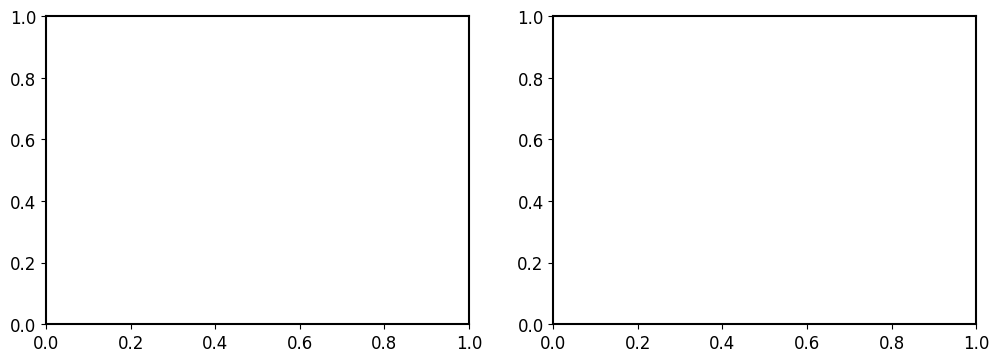

In [10]:
# =============================================================================
# Plot Training Progress
# =============================================================================
try: 
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    ax1 = axes[0]
    ax1.plot(episode_rewards, 'b-', alpha=0.5, linewidth=0.8)
    window = 10
    if len(episode_rewards) >= window:
        smoothed = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(episode_rewards)), smoothed, 'r-', linewidth=2, label=f'{window}-ep avg')
    ax1.set_xlabel('Episode'); ax1.set_ylabel('Reward'); ax1.set_title('Training Rewards')
    ax1.legend(); ax1.grid(True)

    ax2 = axes[1]
    ax2.plot(episode_lengths, 'g-', alpha=0.5, linewidth=0.8)
    ax2.axhline(env.max_steps, color='r', linestyle='--', label='Target')
    if len(episode_lengths) >= window:
        smoothed_len = np.convolve(episode_lengths, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(episode_lengths)), smoothed_len, 'b-', linewidth=2, label=f'{window}-ep avg')
    ax2.set_xlabel('Episode'); ax2.set_ylabel('Length'); ax2.set_title('Episode Lengths')
    ax2.legend(); ax2.grid(True)

    plt.tight_layout()
    plt.show()
except: 
    print("Matplotlib not available or plotting failed.")

## 5. Evaluate and Compute Strain Sensitivity

In [11]:
# =============================================================================
# Evaluate Trained Agent with Probe Noise Injection
# =============================================================================

def evaluate_with_probe_noise(mpo_agent, env, n_rollouts=10, eval_steps=8192, probe_noise_level=1e-8):
    """
    Evaluate agent with broadband probe noise injection for system identification.
    
    Args:
        mpo_agent: Trained MPO agent
        env: PitchControlEnv instance
        n_rollouts: Number of rollouts to average
        eval_steps: Steps per rollout
        probe_noise_level: Amplitude of broadband probe noise
    
    Returns:
        all_errors: List of error arrays from each rollout
        all_actions: List of action arrays from each rollout
        all_pitches: List of pitch arrays from each rollout
    """
    all_errors = []
    all_actions = []
    all_pitches = []
    
    original_max_steps = env.max_steps
    env.max_steps = eval_steps
    
    for rollout in range(n_rollouts):
        obs, _ = env.reset()
        done = False
        
        while not done:
            # Get deterministic action from policy
            action = mpo_agent.policy.get_action(
                torch.FloatTensor(obs).unsqueeze(0).to(device), 
                deterministic=True
            )[0]
            action *= 0.5
            
            # Inject small broadband probe noise into action
            probe_noise = np.random.randn() * probe_noise_level / env.action_scale
            action_with_probe = np.clip(action + probe_noise, -1.0, 1.0)
            
            obs, reward, terminated, truncated, info = env.step(action_with_probe)
            done = terminated or truncated
        
        all_errors.append(np.array(env.error_history_full))
        all_actions.append(np.array(env.action_history_full))
        all_pitches.append(np.array(env.pitch_history))
        
        print(f"Rollout {rollout+1}/{n_rollouts}: {len(env.pitch_history)} steps, "
              f"RMS pitch = {np.std(env.pitch_history):.3e} rad")
    
    env.max_steps = original_max_steps
    return all_errors, all_actions, all_pitches


def estimate_controller_from_rollouts(all_errors, all_actions, fs, nperseg=2048):
    """
    Estimate controller frequency response C_nn(f) = -P_uy(f) / P_yy(f)
    averaged over multiple rollouts.
    
    Note: Negative sign for proper feedback convention (negative feedback loop).
    Controller output u = -C * y in standard feedback.
    """
    # Collect all CSD and PSD estimates
    Puy_sum = None
    Pyy_sum = None
    n_valid = 0
    
    for errors, actions in zip(all_errors, all_actions):
        if len(errors) < nperseg:
            continue
            
        f_csd, Puy = csd(errors, actions, fs=fs, nperseg=nperseg)
        f_psd, Pyy = welch(errors, fs=fs, nperseg=nperseg)
        
        if Puy_sum is None:
            Puy_sum = Puy
            Pyy_sum = Pyy
        else:
            Puy_sum += Puy
            Pyy_sum += Pyy
        n_valid += 1
    
    if n_valid == 0:
        raise ValueError("No valid rollouts for controller estimation")
    
    # Average
    Puy_avg = Puy_sum / n_valid
    Pyy_avg = Pyy_sum / n_valid
    
    # Controller estimate with NEGATIVE sign for proper feedback convention
    # In negative feedback: u = -C * e, so C = -P_ue / P_ee
    C_nn_est = -Puy_avg / (Pyy_avg + 1e-30)
    
    return f_csd, C_nn_est, Pyy_avg


# Run evaluation with probe noise
print("="*60)
print("Evaluating with probe noise injection")
print("="*60)

n_eval_rollouts = 5
eval_steps = 8192 
probe_noise_level = 0.0

all_errors, all_actions, all_pitches = evaluate_with_probe_noise(
    mpo, env, n_rollouts=n_eval_rollouts, eval_steps=eval_steps, probe_noise_level=probe_noise_level
)

print(f"\nCompleted {n_eval_rollouts} evaluation rollouts")
print(f"Average pitch RMS: {np.mean([np.std(p) for p in all_pitches]):.3e} rad")

Evaluating with probe noise injection


Rollout 1/5: 7001 steps, RMS pitch = 1.599e-06 rad
Rollout 2/5: 6843 steps, RMS pitch = 1.605e-06 rad
Rollout 3/5: 6951 steps, RMS pitch = 1.530e-06 rad
Rollout 4/5: 7361 steps, RMS pitch = 1.504e-06 rad
Rollout 5/5: 6651 steps, RMS pitch = 1.552e-06 rad

Completed 5 evaluation rollouts
Average pitch RMS: 1.558e-06 rad


In [12]:
# =============================================================================
# Compute Strain Sensitivity via Closed-Loop Frequency-Domain Equations
# =============================================================================

# Estimate NN controller frequency response (averaged over rollouts)
# Note: Sign convention fixed in estimate_controller_from_rollouts
f_csd, C_nn_est, Pyy_avg = estimate_controller_from_rollouts(
    all_errors, all_actions, fs=fs, nperseg=2048
)
print(f"Controller estimated over {len(all_errors)} rollouts")

# Design linear controller (baseline for comparison)
K = 5e4
z1, z2 = 2 * np.pi * 0.5, 2 * np.pi * 3.0
p1, p2, p3 = 2 * np.pi * 0.1, 2 * np.pi * 30.0, 2 * np.pi * 50.0
C_linear = K * (s + z1) * (s + z2) / ((s + p1) * (s + p2) * (s + p3))

# Linear controller closed-loop
L_lin, S_lin, T_lin = compute_closed_loop(P_plant, C_linear)
strain_lin, pitch_lin, seismic_lin, sensor_lin = compute_strain_asd(
    freq, H_topL_interp, S_lin, T_lin, sei_asd_interp, sensor_asd_interp, coupling
)

# NN controller closed-loop (using identified controller)
C_nn_interp = interp_complex(freq, f_csd, C_nn_est)
L_nn, S_nn, T_nn = compute_closed_loop(P_plant, C_nn_interp)
strain_nn, pitch_nn_fd, seismic_nn, sensor_nn = compute_strain_asd(
    freq, H_topL_interp, S_nn, T_nn, sei_asd_interp, sensor_asd_interp, coupling
)

# =============================================================================
# Uncertainty Bands from Randomized Plant Parameters
# =============================================================================

def compute_strain_with_plant_uncertainty(freq, s, plant_zeros, plant_poles, plant_gain, 
                                          C_controller, H_sus, sei_asd, sensor_asd, coupling,
                                          n_samples=50, pole_uncertainty=0.1, gain_uncertainty=0.2):
    """
    Compute strain ASD with uncertainty bands from randomized plant parameters.
    """
    np.random.seed(42)
    all_strain = []
    
    for i in range(n_samples):
        # Randomize plant parameters
        pole_perturbation = 1 + pole_uncertainty * np.random.randn(len(plant_poles))
        perturbed_poles = plant_poles * pole_perturbation
        
        gain_perturbation = 1 + gain_uncertainty * np.random.randn()
        perturbed_gain = plant_gain * gain_perturbation
        
        # Compute perturbed plant
        P_perturbed = zpk_freqresp(plant_zeros, perturbed_poles, perturbed_gain, s)
        
        # Closed-loop with perturbed plant
        L, S, T = compute_closed_loop(P_perturbed, C_controller)
        
        # Strain ASD
        strain, _, _, _ = compute_strain_asd(freq, H_sus, S, T, sei_asd, sensor_asd, coupling)
        all_strain.append(strain)
    
    all_strain = np.array(all_strain)
    
    # Compute percentiles
    strain_lower = np.percentile(all_strain, 16, axis=0)
    strain_median = np.percentile(all_strain, 50, axis=0)
    strain_upper = np.percentile(all_strain, 84, axis=0)
    
    return strain_lower, strain_median, strain_upper

# Compute uncertainty bands for NN controller
strain_nn_lower, strain_nn_median, strain_nn_upper = compute_strain_with_plant_uncertainty(
    freq, s, plant_zeros, plant_poles, plant_gain,
    C_nn_interp, H_topL_interp, sei_asd_interp, sensor_asd_interp, coupling,
    n_samples=50, pole_uncertainty=0.15, gain_uncertainty=0.25
)

# Compute uncertainty bands for linear controller
strain_lin_lower, strain_lin_median, strain_lin_upper = compute_strain_with_plant_uncertainty(
    freq, s, plant_zeros, plant_poles, plant_gain,
    C_linear, H_topL_interp, sei_asd_interp, sensor_asd_interp, coupling,
    n_samples=50, pole_uncertainty=0.15, gain_uncertainty=0.25
)

# NO SMOOTHING - show raw data until loop-shaping is verified
# (Nyquist sane, |S| < 1 at low-f, |T| rolls off correctly)
print("Strain sensitivity computed via closed-loop frequency-domain equations")
print(f"Uncertainty bands from {50} randomized plant parameter samples")
print("NOTE: No smoothing applied - showing raw frequency response")

Controller estimated over 5 rollouts
Strain sensitivity computed via closed-loop frequency-domain equations
Uncertainty bands from 50 randomized plant parameter samples
NOTE: No smoothing applied - showing raw frequency response


## 6. Results

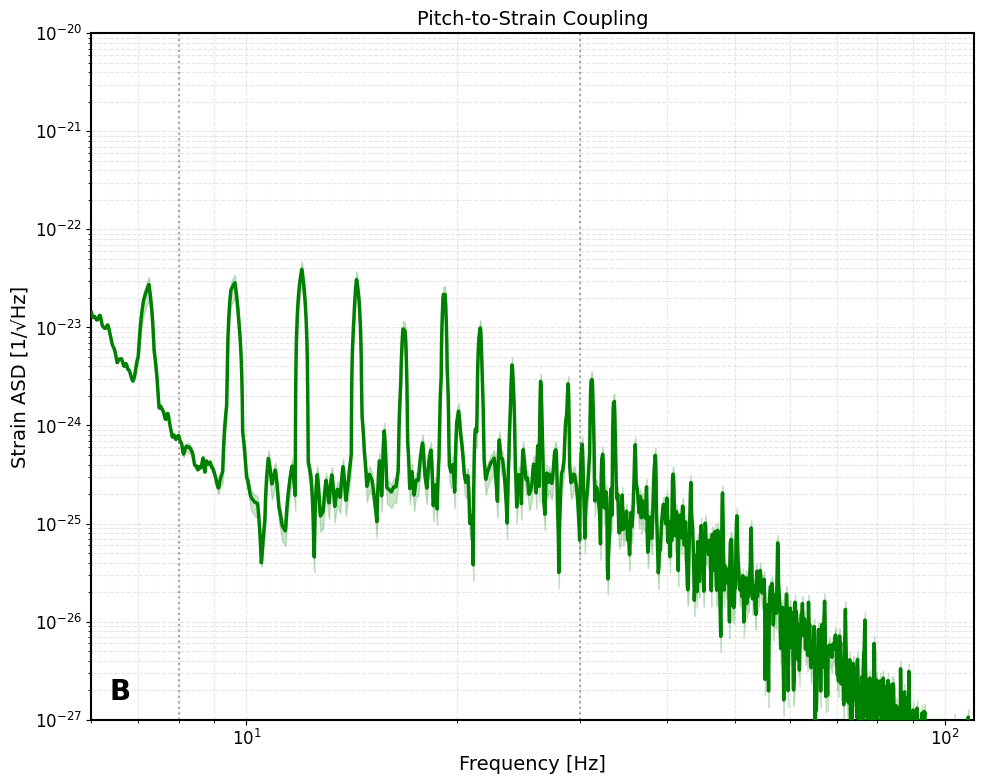


Strain sensitivity computed via closed-loop frequency-domain equations
NO SMOOTHING applied - verify loop-shaping before enabling


In [36]:
# =============================================================================
# MAIN PLOT: Strain Sensitivity Comparison (NO SMOOTHING)
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 8))

mask = (freq >= 6) & (freq <= 110)
f_plot = freq[mask]

# Design spec: quantum limit / 10
h_sql = 1e-23 * np.sqrt(10 / f_plot)
design_spec = h_sql / 10

# Plot design specification
# ax.loglog(f_plot, design_spec, 'g--', linewidth=2.5, label='Design spec: quantum limit / 10', zorder=1)

# Plot A+ reference (scaled)
# ax.loglog(f_plot, aplus_interp[mask] * 2, color='purple', alpha=0.4, linewidth=2, 
#           label='LIGO Strain (measured)', zorder=0)

# # Linear controller with uncertainty band
# ax.fill_between(f_plot, strain_lin_lower[mask], strain_lin_upper[mask], 
#                 color='red', alpha=0.15, zorder=2)
# ax.loglog(f_plot, strain_lin[mask], 'r-', linewidth=2.5, 
#           label='Linear controller (baseline)', zorder=3)

# NN controller with uncertainty band (NO SMOOTHING)
ax.fill_between(f_plot, strain_nn_lower[mask], strain_nn_upper[mask], 
                                color='green', alpha=0.2, zorder=4)
ax.loglog(f_plot, strain_nn[mask], 'g-', linewidth=2.5, 
                  label='NN controller (ours)', zorder=5)

# Add vertical dotted lines at band boundaries
ax.axvline(3.0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, zorder=2)
ax.axvline(8.0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, zorder=2)
ax.axvline(30.0, color='gray', linestyle=':', linewidth=1.5, alpha=0.7, zorder=2)

ax.set_xlabel('Frequency [Hz]', fontsize=14)
ax.set_ylabel('Strain ASD [1/√Hz]', fontsize=14)
ax.set_xlim([6, 110])
ax.set_ylim([1e-27, 1e-20])
ax.grid(True, which='both', linestyle='--', alpha=0.3)
# ax.legend(loc='upper right', fontsize=11)
ax.set_title('Pitch-to-Strain Coupling', fontsize=14)
ax.text(0.02, 0.02, 'B', transform=ax.transAxes, fontsize=20, fontweight='bold', 
                verticalalignment='bottom')

plt.tight_layout()
plt.show()

print("\nStrain sensitivity computed via closed-loop frequency-domain equations")
print("NO SMOOTHING applied - verify loop-shaping before enabling")

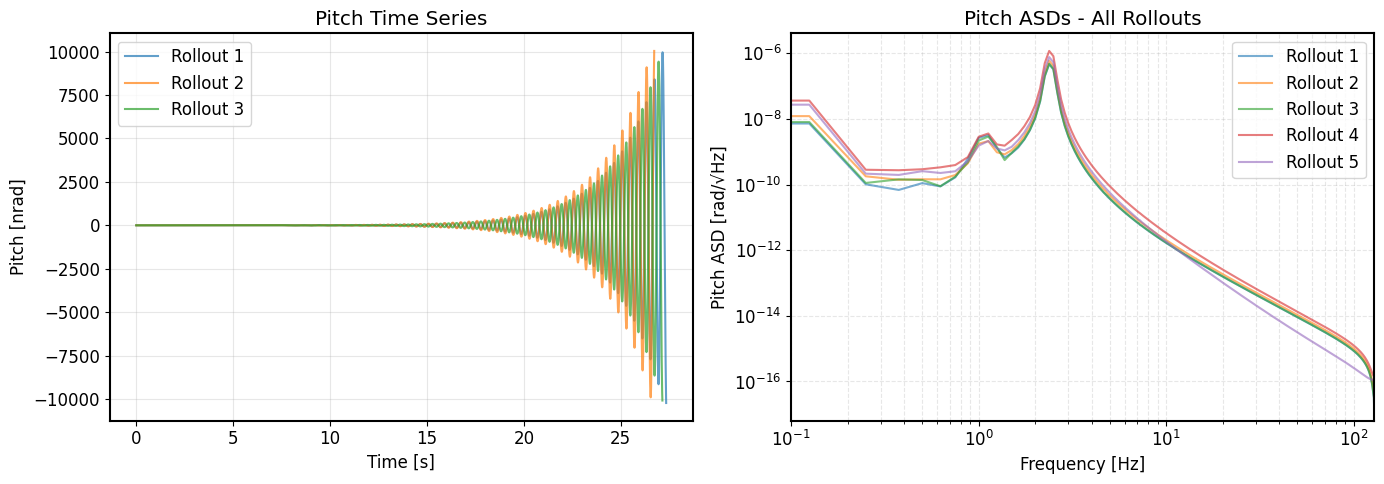

RMS of true pitch motion from 0-3 Hz: 341.60 nrad


In [33]:
# =============================================================================
# True Pitch Time Series and ASDs from Rollouts
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5),)

# Time series plots
for i, pitch_data in enumerate(all_pitches[:3]):  # Plot first 3 rollouts
    t = np.arange(len(pitch_data)) / fs
    axes[0].plot(t, pitch_data * 1e9, alpha=0.7, label=f'Rollout {i+1}')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Pitch [nrad]')
axes[0].set_title('Pitch Time Series')
axes[0].legend()
axes[0].grid(True, alpha=0.3)


# ASDs
for i, pitch_data in enumerate(all_pitches):
    f_pitch, pitch_asd = welch(pitch_data, fs=fs, nperseg=2048)
    axes[1].loglog(f_pitch, np.sqrt(pitch_asd), alpha=0.6, label=f'Rollout {i+1}')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('Pitch ASD [rad/√Hz]')
axes[1].set_title('Pitch ASDs - All Rollouts')
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', alpha=0.3)
axes[1].set_xlim([0.1, fs/2])

plt.tight_layout()
plt.show()

# Calculate RMS of true pitch motion from 0 to 3 Hz
all_psds = []
for pitch_data in all_pitches:
    f_pitch, pitch_psd = welch(pitch_data, fs=fs, nperseg=2048)
    all_psds.append(pitch_psd)
avg_psd = np.mean(all_psds, axis=0)
mask_3hz = (f_pitch >= 0) & (f_pitch <= 3.0)
rms_pitch_0_3hz = np.sqrt(np.trapezoid(avg_psd[mask_3hz], f_pitch[mask_3hz]))
print(f"RMS of true pitch motion from 0-3 Hz: {rms_pitch_0_3hz*1e9:.2f} nrad")


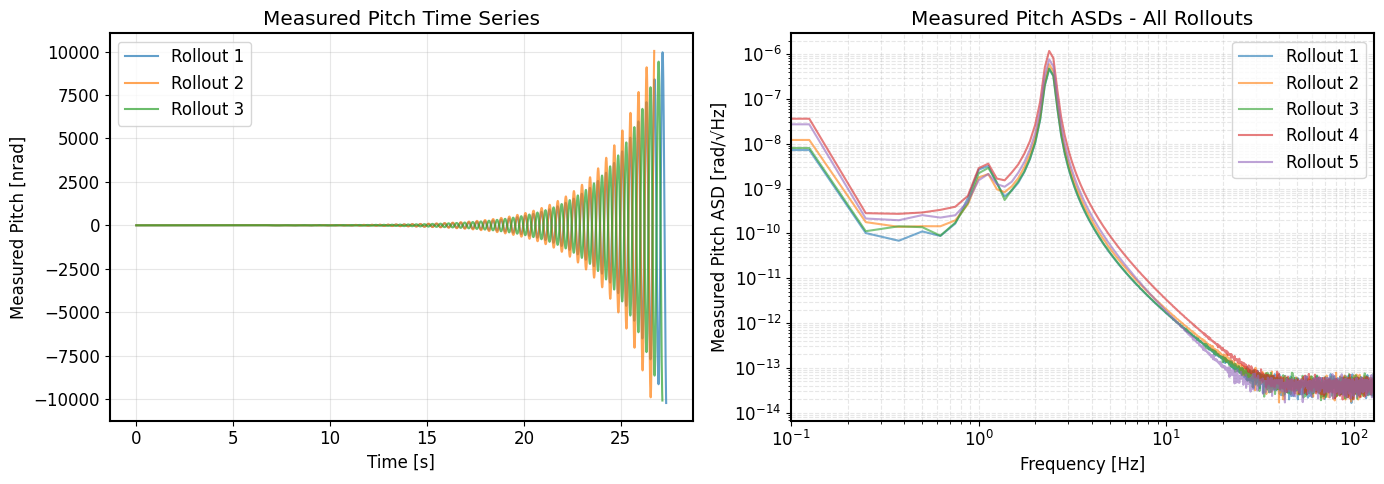

RMS of in-loop error signal (residual pitch) from 0-3 Hz: 341.60 nrad


In [31]:
# =============================================================================
# Measured Pitch (Error) Time Series and ASDs from Rollouts
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Time series plots
for i, error_data in enumerate(all_errors[:3]):  # Plot first 3 rollouts
    t = np.arange(len(error_data)) / fs
    axes[0].plot(t, error_data * 1e9, alpha=0.7, label=f'Rollout {i+1}')
axes[0].set_xlabel('Time [s]')
axes[0].set_ylabel('Measured Pitch [nrad]')
axes[0].set_title('Measured Pitch Time Series')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ASDs
for i, error_data in enumerate(all_errors):
    f_error, error_asd = welch(error_data, fs=fs, nperseg=2048)
    axes[1].loglog(f_error, np.sqrt(error_asd), alpha=0.6, label=f'Rollout {i+1}')
axes[1].set_xlabel('Frequency [Hz]')
axes[1].set_ylabel('Measured Pitch ASD [rad/√Hz]')
axes[1].set_title('Measured Pitch ASDs - All Rollouts')
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--', alpha=0.3)
axes[1].set_xlim([0.1, fs/2])

# Average ASD
all_error_psds = []
for error_data in all_errors:
    f_error, error_psd = welch(error_data, fs=fs, nperseg=2048)
    all_error_psds.append(error_psd)
avg_error_psd = np.mean(all_error_psds, axis=0)
std_error_psd = np.std(all_error_psds, axis=0)

plt.tight_layout()
plt.show()

# Calculate RMS of in-loop error signal (measured pitch) from 0 to 3 Hz
mask_3hz_error = (f_error >= 0) & (f_error <= 3.0)
rms_error_0_3hz = np.sqrt(np.trapezoid(avg_error_psd[mask_3hz_error], f_error[mask_3hz_error]))
print(f"RMS of in-loop error signal (residual pitch) from 0-3 Hz: {rms_error_0_3hz*1e9:.2f} nrad")

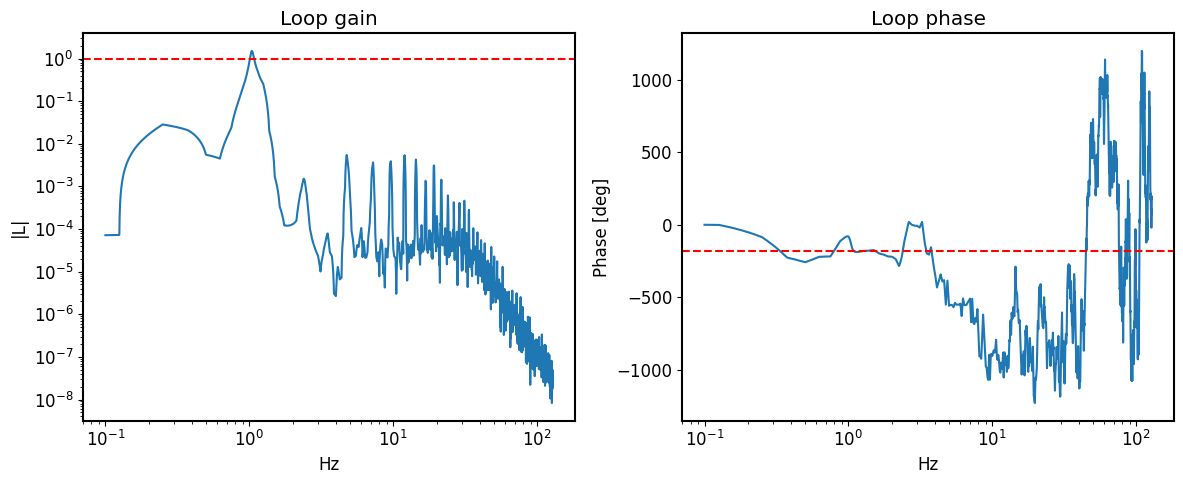

In [16]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.loglog(freq, np.abs(L_nn))
plt.axhline(1, color='r', linestyle='--')
plt.xlabel("Hz")
plt.ylabel("|L|")
plt.title("Loop gain")

plt.subplot(1,2,2)
plt.semilogx(freq, np.unwrap(np.angle(L_nn)) * 180/np.pi)
plt.axhline(-180, color='r', linestyle='--')
plt.xlabel("Hz")
plt.ylabel("Phase [deg]")
plt.title("Loop phase")

plt.tight_layout()
plt.show()


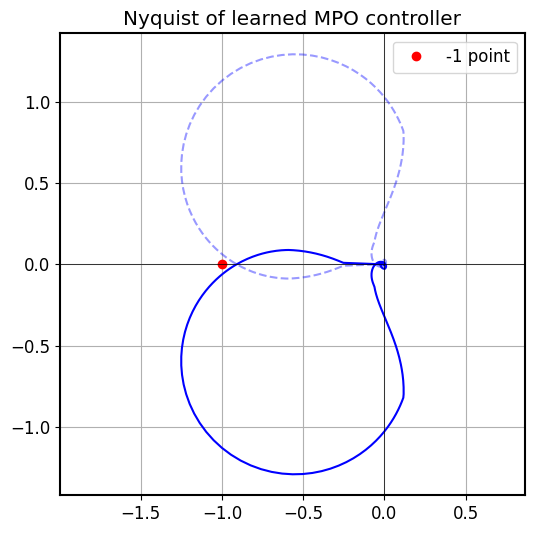

In [17]:
plt.figure(figsize=(6,6))
plt.plot(L_nn.real, L_nn.imag, 'b-')
plt.plot(L_nn.real, -L_nn.imag, 'b--', alpha=0.4)  # mirror
plt.plot(-1, 0, 'ro', label='-1 point')
plt.axhline(0,color='k',linewidth=0.5)
plt.axvline(0,color='k',linewidth=0.5)
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.title("Nyquist of learned MPO controller")
plt.show()
